In [89]:
import torch 
import matplotlib.pyplot as plt 
#%matplotlib inline
import numpy as np
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes, AdaptiveLIFNodes
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor
from bindsnet.analysis.plotting import plot_spikes, plot_voltages, plot_weights
from bindsnet.learning import PostPre
from bindsnet.analysis.visualization import summary, plot_spike_trains_for_example, plot_voltage
from bindsnet import encoding



In [78]:
#define the helper's function

def loss_output(y,a_out):
    '''
    calculate the objective/Loss function
    at the last layer
    output : Loss tensor
    :param y (tensor): target label : 
    :param a_out (tensor): spike activity at the output layer
    '''
    o_de = 1 if (torch.max(torch.sum(a_out,dim=0))==0) else torch.max(torch.sum(a_out,dim=0))
    #o = torch.sum(a_out,dim=0) / torch.max(torch.sum(a_out,dim=0))    
    o = torch.sum(a_out,dim=0) / o_de   
    Loss = 0.5 * torch.pow(torch.norm(o - y),2)
    return Loss

def error_backprop_out(y,a_out):
    '''
    calculate the error at the output layer
    output : loss tensor
    param
    param
    '''
    o_de = 1 if (torch.max(torch.sum(a_out,dim=0))==0) else torch.max(torch.sum(a_out,dim=0))
    #o_vec = torch.sum(a_out,dim=0) / torch.max(torch.sum(a_out,dim=0))
    o_vec = torch.sum(a_out,dim=0) / o_de
    #denom = 1 if (np.sqrt(torch.count_nonzero(o_vec - y)) == 0) else np.sqrt(torch.count_nonzero(o_vec - y))
    denom = np.sqrt(torch.count_nonzero(o_vec - y))
    delta_Loss = (o_vec - y) / (denom +1)
    return delta_Loss


def error_backprop(net,a_hidden,a_out,deltai_nxt):
    '''
    calculate the backprop error for each layer except output layer
    output : the error backprop tensor with dimension 1 x Number of neurons in that layer
    :param : net, network object
    :input : input data
    :a_hidden : spike activity output at the hidden layer
    :a_out : spike activit output at the output/last layer
    :deltai_nxt : backprop error from the next layer
    '''
    w = list(net.parameters())
    wij = w[2]          #get the weight of the hidden layer
    Vth = net.layers["B"].thresh
    M = net.layers["B"].n#total synapses in the next layer
    m = torch.sum(a_out,dim=0).nonzero()#vector of active synapses in the next layer  
    n = torch.sum(a_hidden,dim=0).nonzero() #vector of active neuron in the next layer
    #n = 1 if (torch.sum(a_hidden,dim=0).nonzero()==0) else torch.sum(a_hidden,dim=0).nonzero()
    g_i   = 1 / Vth
    g_bar = np.sqrt((1/(1+len(n))) * torch.sum(torch.pow(g_i[n],2)))
    deltai = (g_i / g_bar) * np.sqrt(M/(1+len(m))) * (wij @ deltai_nxt)
    return deltai
    #return g_bar
    
def delta_weight(etaw,N,m,deltai,xj):
    '''
    calculate the delta weights in each layer
    output : the vector of weight of each layer
    input : etaw, learning rate
    input : N, total neuron in layer
    input : m, total of active synapses in layer
    input : deltai, vector of error backprop
    input : xj,vector of effective input spike activity
    '''
    di = torch.reshape(deltai,[1,len(deltai)])
    x_j = torch.sum(xj,dim=0)
    x_j = x_j.reshape([len(x_j),1])
    return -etaw * np.sqrt(N/(1+m)) * di * x_j

def delta_thrs(etath,N,m,M,deltai,ai):
    '''
    calculate the delta threshold in each neuron in layer
    output : the vector of voltage threshold of each layer
    input : etath, learning rate
    input : N, total neuron in layer
    input : m, total of active synapses in layer
    input : M, total synapses in the layer
    input : deltai, vector of error backprop
    input : xj,vector of effective output spike activity
    '''
    #di  = torch.reshape(deltai,[1,len(deltai)])
    #a_i = torch.sum(ai,dim=0)
    #a_i = a_i.reshape([len(a_i),1])
    return -etath * np.sqrt(N/((1+m)*M)) * deltai * torch.sum(ai,dim=0)

def calculate_gradient(net,etaw,etath,di_out,di_hid,a_out,a_hid,x_out,x_hid):
    '''
    calculate the gradient of weights and voltage threshold
    output : tensor to update the weights and thresholds
    input : net, network object 
    input : 
    input :
    input :
    '''
    N_out   = net.layers["C"].n#total neuron in the output layer
    N_hid   = net.layers["B"].n#total neuron in the hidden layer
    M_out   = N_hid #total synapses in the output layer
    M_hid   = net.layers["A"].n#total synapses in the hidden layer

    m_out   = len(torch.sum(a_out,dim=0).nonzero())#total active synapses in the output layer
    m_hid   = len(torch.sum(a_hidden,dim=0).nonzero())#total active synapses in the hidden layer


    #1. weight in the last layer
    dwout = delta_weight(etaw,N_out,m_out,di_out,x_out)    
    
    #2. weight in the middle layer
    dwhid = delta_weight(etaw,N_hid,m_hid,di_hid,x_hid)
    
    #3. threshold in the last layer
    d_thout = delta_thrs(etath,N_out,m_out,M_out,di_out,a_out)
    
    #4. threshold in the middle layer
    d_thid = delta_thrs(etath,N_hid,m_hid,M_hid,di_hid,a_hid)

    #store the information gradient in the dictionary
    params = {"wo" : dwout,
              "wh" : dwhid,
              "to" : d_thout,
              "th" : d_thid
            }
    
    return params

def accumulate_paramaters(params_tmp,params):
    '''
    add two parameters
    output new parameters
    input params
    input params_tmp
    '''

    var1 = params_tmp["wo"] + params["wo"]
    var2 = params_tmp["wh"] + params["wh"]
    var3 = params_tmp["to"] + params["to"]
    var4 = params_tmp["th"] + params["th"]

    param_out = {
                "wo":var1,
                "wh":var2,
                "to":var3,
                "th":var4
    }
    return param_out


def update_weigth_threshold(net,params):
    '''
    update the weights and voltage threshold parameters
    input : net , network object
    input : params, dictionary containing gradient of weights and thresholds
    '''

    w   = list(net.parameters())
    vth = [net.layers["B"].thresh,net.layers["C"].thresh]

    dwout = params["wo"]
    dwhid = params["wh"]
    d_thout = params["to"]
    d_thid = params["th"]


    w[2].add_(dwout) #update the weights in the last layer
    w[0].add_(dwhid) #update the weights in the hidden layer 
    vth[1].add_(d_thout) #update the threshold in the last layer
    vth[0].add_(d_thid) #update the threshold in the hidden layer



def update_params(net,etaw,etath,di_out,di_hid,a_out,a_hid,x_out,x_hid):
    '''torch.max(torch.sum(a_out,dim=0))
    calculate the delta weights and thresholds and update its value
    :input : net
    :
    '''
    N_out   = net.layers["C"].n#total neuron in the output layer
    N_hid   = net.layers["B"].n#total neuron in the hidden layer
    M_out   = N_hid #total synapses in the output layer
    M_hid   = net.layers["A"].n#total synapses in the hidden layer

    m_out   = len(torch.sum(a_out,dim=0).nonzero())#total active synapses in the output layer
    m_hid   = len(torch.sum(a_hidden,dim=0).nonzero())#total active synapses in the hidden layer

    w   = list(net.parameters())
    vth = [net.layers["B"].thresh,net.layers["C"].thresh]

    #1. weight in the last layer
    dwout = delta_weight(etaw,N_out,m_out,di_out,x_out)    
    w[2].add_(dwout) #update the parameters
    #2. weight in the middle layer
    dwhid = delta_weight(etaw,N_hid,m_hid,di_hid,x_hid)
    w[0].add_(dwhid) #update the parameters
    #print("last layer delta w ",dwout)
    
    #3. threshold in the last layer
    d_thout = delta_thrs(etath,N_out,m_out,M_out,di_out,a_out)
    vth[1].add_(d_thout)
    #4. threshold in the middle layer
    d_thid = delta_thrs(etath,N_hid,m_hid,M_hid,di_hid,a_hid)
    vth[0].add_(d_thid)

    
    

In [98]:
#simulation time
time = 350 #in millisecond
batch = 4 #batch size
decay_time = 150 #wait till the membrane voltage to decay
#other parameters according Lee et.al(2016)
alpha = [10 ,3]
beta  = 10
lamda = 0.002
rho   = 0.0001
eta_w  = 0.002        #learning rate for synaptic weight
eta_th = 0.1 * eta_w  #learning rate for voltage threshold
T_ref = 1               #refractory period
t_mp  = 20            #decay time
v_rest = -65          #default neuron rest voltage
v_thresh   = -52          #default neuron threshold voltage

#create the network
network = Network()
#create and add input, output layers

#voltage threshold as a vector 
# the value corresponds to every vth in each node
nodes = [20, 40, 4] #number of nodes in each layer

#initialize the voltage threshold
vth = [alpha[0]*np.sqrt(3.0/nodes[0]), alpha[1]*np.sqrt(3.0/nodes[1])]


thres1 = (v_rest+ vth[0]) + torch.zeros(1,nodes[1])
thres2 = (v_rest+vth[1]) + torch.zeros(1,nodes[2])

source_layer = Input(n=nodes[0],traces=True)
hidden_layer = LIFNodes(n=nodes[1],trace=True,refrac=T_ref,thresh=thres1.squeeze(),tc_decay=t_mp,lbound=v_rest - vth[0])
target_layer = LIFNodes(n=nodes[2],traces=True,refrac=T_ref,thresh=thres2.squeeze(),tc_decay=t_mp,lbound=v_rest - vth[1])
#target_layer = AdaptiveLIFNodes(n=4, traces=True,refrac=1,thresh=)

network.add_layer(
    layer = source_layer, name="A"
)
network.add_layer(
    layer = hidden_layer, name="B"
)
network.add_layer(
    layer = target_layer, name="C"
)

#print("voltage threshold in output layer neuron "+str(network.layers["C"].thresh))
#print("voltage threshold in hidden layer neuron "+str(network.layers["B"].thresh))
#create a connection between input and hidden layers
forward_connection1 = Connection(
    source = source_layer,
    target= hidden_layer,
    #weight initialization according to Lee et.al
    #w=0.05 + 0.1 * torch.randn(source_layer.n, hidden_layer.n),
    w = (np.sqrt(3.0/source_layer.n)) - 2*np.sqrt(3.0/source_layer.n)*torch.rand(source_layer.n, hidden_layer.n),
)

network.add_connection(
    connection=forward_connection1, source="A", target="B"
)

#create a connection between hidden layer and output layer
forward_connection2 = Connection(
    source = hidden_layer,
    target = target_layer,
    #weight initialization according to Lee et.al
    #w=0.05 + 0.1 * torch.randn(hidden_layer.n, target_layer.n),
    w = (np.sqrt(3.0/hidden_layer.n)) - 2*np.sqrt(3.0/hidden_layer.n)*torch.rand(hidden_layer.n, target_layer.n),
    
)

network.add_connection(
    connection=forward_connection2, source="B", target="C"
)

#create a recurrent connection in output layer
# Winner take all circuit
recurrent_connection = Connection(
    source = target_layer,
    target= target_layer,
    w = 0.001 * (torch.eye(target_layer.n)-1),
    #w = 0.4 * (torch.eye(target_layer.n)-1),
)

network.add_connection(
    connection=recurrent_connection, source="C", target="C"
)

#create and add input and output layer monitor
source_monitor = Monitor(
    obj = source_layer,
    state_vars = ("s",), #record spikes and voltages
    time = time , 
)

hidden_monitor = Monitor(
    obj = hidden_layer,
    state_vars=("s","v"),
    time = time ,
)

target_monitor = Monitor(
    obj = target_layer,
    state_vars= ("s", "v"),
    time = time ,
)

network.add_monitor(monitor=source_monitor, name="A")
network.add_monitor(monitor=hidden_monitor, name="B")
network.add_monitor(monitor=target_monitor, name="C")
#print th network summary
print(summary(network))

         NETWORK SUMMARY
         batch size:1
    ··········································
    Layer: 'A' (trainable)
   20 neurons [20]
       ·connected to 'B' by 800 synapses
    ··········································
    Layer: 'B' (trainable)
   40 neurons [40]
       ·connected to 'C' by 160 synapses
    ··········································
    Layer: 'C' (trainable)
   4 neurons [4]
       ·connected to 'C' by 16 synapses
Total neurons: 64 (64 trainable)
Total synapses weights: 976 (976 trainable)


In [91]:
#investigate the weight in forward and recurrent connection
w1 = forward_connection1.w
w2 = forward_connection2.w
k1 = recurrent_connection.w 
vth1 = network.layers["B"].thresh
vth2 = network.layers["C"].thresh
print("max and min of 1st forward connection weights"+str(torch.max(w1))+" "+str(torch.min(w1)))
print("max and min of 2nd forward connection weights"+str(torch.max(w2))+" "+str(torch.min(w2)))
print("max and min of recurrent weights "+str(torch.max(k1))+" "+str(torch.min(k1)))
print("voltage threshold hidden layer",vth1)
print("voltage threshold output layer",vth2)

max and min of 1st forward connection weightstensor(0.3854) tensor(-0.3869)
max and min of 2nd forward connection weightstensor(0.2726) tensor(-0.2707)
max and min of recurrent weights tensor(0.) tensor(-0.0010)
voltage threshold hidden layer tensor([-61.1270, -61.1270, -61.1270, -61.1270, -61.1270, -61.1270, -61.1270,
        -61.1270, -61.1270, -61.1270, -61.1270, -61.1270, -61.1270, -61.1270,
        -61.1270, -61.1270, -61.1270, -61.1270, -61.1270, -61.1270, -61.1270,
        -61.1270, -61.1270, -61.1270, -61.1270, -61.1270, -61.1270, -61.1270,
        -61.1270, -61.1270, -61.1270, -61.1270, -61.1270, -61.1270, -61.1270,
        -61.1270, -61.1270, -61.1270, -61.1270, -61.1270])
voltage threshold output layer tensor([-64.1784, -64.1784, -64.1784, -64.1784])


In [92]:
#check wheter or not the weigths satisfy the equation 11
print(forward_connection1.w)
print(torch.sum(torch.pow((forward_connection1.w),2),dim=0))

Parameter containing:
tensor([[-3.8688e-01,  1.7968e-01, -6.1006e-03,  1.6757e-01, -9.9369e-02,
          1.7118e-01,  2.0119e-01, -3.3896e-01, -3.4794e-01,  3.6752e-01,
         -3.4602e-01, -1.0939e-01,  4.7792e-02,  3.5584e-01, -3.4826e-01,
          3.3888e-01,  2.0491e-01, -3.5119e-01, -6.1243e-02, -9.0045e-02,
          2.2947e-01, -2.3103e-01, -9.0583e-02, -3.5735e-01, -1.7940e-01,
          2.5897e-01,  2.3249e-01,  1.7476e-01,  2.4764e-02, -3.4679e-01,
          1.2558e-01, -1.6829e-01, -1.2728e-01, -1.8804e-01, -5.1959e-02,
         -4.7535e-02,  8.8893e-02,  2.5824e-01, -2.9615e-01,  1.3630e-01],
        [ 3.0687e-01, -2.0167e-01,  2.2882e-01,  8.0745e-02,  1.1365e-02,
         -2.2894e-01,  3.6007e-02,  3.1567e-02,  6.7967e-02,  9.2946e-02,
          3.4084e-01,  1.0412e-01,  3.4736e-02,  1.6784e-01, -2.7532e-01,
         -3.3352e-01, -1.1879e-01,  1.0461e-01,  1.1263e-01, -3.0751e-01,
         -9.2142e-02,  1.5861e-01, -3.8194e-01,  3.3258e-01, -2.2416e-01,
         -1.791

Target labels  tensor([[0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [1, 0, 0, 0]])


<Figure size 432x288 with 0 Axes>

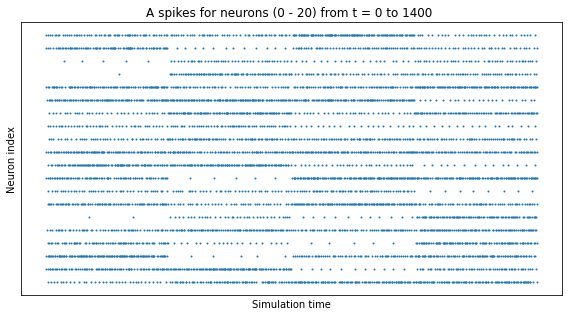

In [99]:
#create input spike data, where each spike is distributed according bernoulli
#input_data = torch.bernoulli(0.1 * torch.ones(time, source_layer.n)).byte()
#inputs = {"A":input_data}

#input_rates = spike_rate * torch.rand(source_layer.n)  # Generate random Poisson rates for N input neurons.
#input_data= encoding.poisson(datum=input_rates, time=time * batch)  # Encode input as time ms Poisson spike trains.
#inputs = {"A":input_data}

spike_rate = 350 #maximum spike rate in hz
input_data = torch.zeros(time * batch , nodes[0])
for j in range(batch):
    input_rates = spike_rate * torch.rand(source_layer.n)
    input_data[j*time:(j*time)+time,:]= encoding.poisson(datum=input_rates, time=time)  

inputs = {"A":input_data}


vary = torch.randint(low=0,high=target_layer.n,size=[batch])
if batch == 1:
    y = torch.tensor([0, 1, 0, 0],dtype=torch.uint8) #target label
else:
    y = torch.nn.functional.one_hot(vary)

print("Target labels ",y)

#plot the input train spike

plt.ioff()
plt.figure()
plot_spikes(inputs)
plt.show()
plt.figure()
plot_weights(forward_connection1.w,wmin=-1,figsize=[7,7])
plt.figure()
plot_weights(forward_connection2.w,wmin=-1,figsize=[7,7])


In [100]:
#begin the training procedure

#loop for 150 epochs
epochs = 50
L = torch.zeros(epochs) #store in the vector
l = torch.zeros(batch)
plot_train = False
y_pred = torch.zeros(batch,nodes[2])

for i in range(epochs): #loop for each epoch     
    for j in range(batch): #loop for each training sample in a batch
        #1. run forward propagation 
        inputs = {"A":input_data[j*time:(j*time)+time,:]}
        network.run(inputs=inputs,time=time)
        #1.1 obtain the spike activity in each nodes of every layer
        #x -> 
        spikes = {
        "A" : source_monitor.get("s"),
        "B" : hidden_monitor.get("s"),
        "C" : target_monitor.get("s")
        }

        voltages = {"B": hidden_monitor.get("v"),
                    "C": target_monitor.get("v")
        }
        
        #plot the spikes and voltages
        
        if plot_train:
            plt.ioff()
            plt.figure()
            plot_spikes(spikes)
            plt.figure()
            plot_voltages(voltages, plot_type="line")
            plt.show()
        #end of the plots
        
        a_hidden = spikes["B"].squeeze().float() #get the spike activity at the hidden layer
        a_out    = spikes["C"].squeeze().float() #get the spike activity at the output layer   

        #save the spike activity value
        y_pred[j,:] = torch.sum(a_out,dim=0)
        
        print(torch.sum(a_out,dim=0)) #print the spike's output activity
        #print(torch.sum(a_hidden,dim=0)) #print the spike's hidden activity

        x_hidden = input_data
        x_out    = a_hidden

        #2. calculate and keep track the loss
        if (batch==1): #if the only one training sample 
            l[j] = loss_output(y,a_out)       #y[j,:] 

            delta_i_out    =  error_backprop_out(y,a_out)#y[j,:]
        else: #multiple training sample in  a batch
            l[j] = loss_output(y[j,:],a_out)       

            delta_i_out    =  error_backprop_out(y[j,:],a_out)
        
        #3.propagate the error backprop
        
        delta_i_hid    =  error_backprop(network,a_hidden,a_out,delta_i_out)    
        #print the delta i
        #print(delta_i_out)
        #print(delta_i_hid)
        
        #4.update the paramaters (weight & threshold)
        update_params(network,eta_w,eta_th,delta_i_out,delta_i_hid,a_out,a_hidden,x_out,x_hidden)
        #print the weight
        #print(forward_connection2.w)
        #print(network.layers["B"].thresh)

        #4. calculate the gradient of weigth and threshold
        #params_tmp = calculate_gradient(network,eta_w,eta_th,delta_i_out,delta_i_hid,a_out,a_hidden,x_out,x_hidden)
        #params = accumulate_paramaters(params_tmp,params)

        #5.reset the membrane potential in the network
        network.layers["C"].reset_state_variables()
        network.layers["B"].reset_state_variables()

        #print(network.layers["C"].thresh)
        #print(network.layers["B"].v)        
    
    #print(network.layers["C"].thresh)
    #print(network.layers["B"].thresh)
    #update the parameters of weight and voltage threshold
    #update_weigth_threshold(network,params)

    L[i] = torch.sum(l)
    print("vector l",l)
    print("epochs , loss : ",i,L[i])
    if L[i] < 0.01: #if the loss is less than specified number
            break #stop the loop



tensor([0., 2., 0., 0.])
tensor([0., 5., 0., 1.])
tensor([ 0., 87.,  0., 55.])
tensor([ 0., 96.,  0., 58.])
vector l tensor([0.0000, 1.0200, 0.5676, 1.1825])
epochs , loss :  0 tensor(2.7702)
tensor([ 2., 79.,  0., 45.])
tensor([ 1., 71.,  0.,  1.])
tensor([12.,  0., 71.,  0.])
tensor([ 0.,  0.,  0., 80.])
vector l tensor([0.1626, 1.0002, 1.0143, 1.0000])
epochs , loss :  1 tensor(3.1770)
tensor([108.,   0.,   0.,   0.])
tensor([  0., 128.,   0.,   0.])
tensor([  0.,   0., 132.,   0.])
tensor([  0.,   0.,   0., 140.])
vector l tensor([1.0000, 1.0000, 1.0000, 1.0000])
epochs , loss :  2 tensor(4.0000)
tensor([148.,   0.,   0.,   0.])
tensor([  0., 152.,   0.,   0.])
tensor([  0.,   0., 157.,   0.])
tensor([  0.,   0.,   0., 162.])
vector l tensor([1.0000, 1.0000, 1.0000, 1.0000])
epochs , loss :  3 tensor(4.0000)
tensor([165.,   0.,   0.,   0.])
tensor([  0., 163.,   0.,   0.])
tensor([  0.,   0., 167.,   0.])
tensor([  0.,   0.,   0., 168.])
vector l tensor([1.0000, 1.0000, 1.0000, 1.0

In [101]:
print("output spike activity")
print(y_pred.int())
print("output spike activity shifted")
print(np.roll(y_pred.int(),shift=-1,axis=0))
print("target label ")
print(y)
#print(a_out.shape)


output spike activity
tensor([[173,   0,   0,   0],
        [  0, 173,   0,   0],
        [  0,   0, 173,   0],
        [  0,   0,   0, 173]], dtype=torch.int32)
output spike activity shifted
[[  0 173   0   0]
 [  0   0 173   0]
 [  0   0   0 173]
 [173   0   0   0]]
target label 
tensor([[0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [1, 0, 0, 0]])


In [102]:
#run the final prediction
y_pred_run = torch.zeros(batch,nodes[2])
for j in range(batch):
    inputs = {"A":input_data[j*time:(j*time)+time,:]}
    network.run(inputs=inputs,time=time)
    a_out    = target_monitor.get("s").squeeze().float()
    y_pred_run[j] = torch.sum(a_out,dim=0)
    #reset state variables 
    #network.layers["C"].reset_state_variables()
    #network.layers["B"].reset_state_variables()
print(y_pred_run)

tensor([[173.,   0.,   0.,   0.],
        [174.,   0.,   0.,   0.],
        [173.,   0.,   0.,   0.],
        [173.,   0.,   0.,   0.]])


<Figure size 432x288 with 0 Axes>

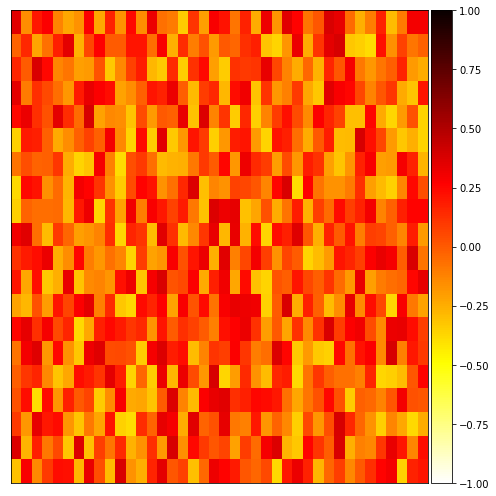

<Figure size 432x288 with 0 Axes>

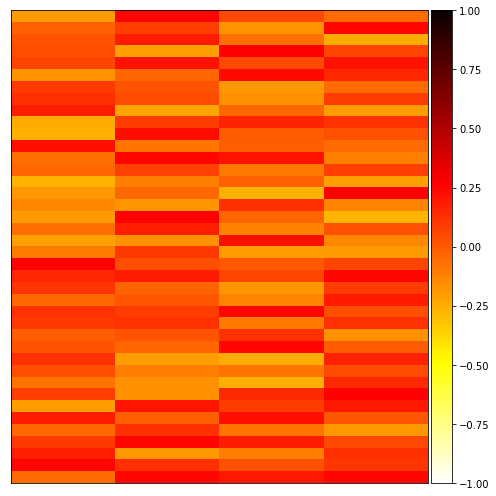

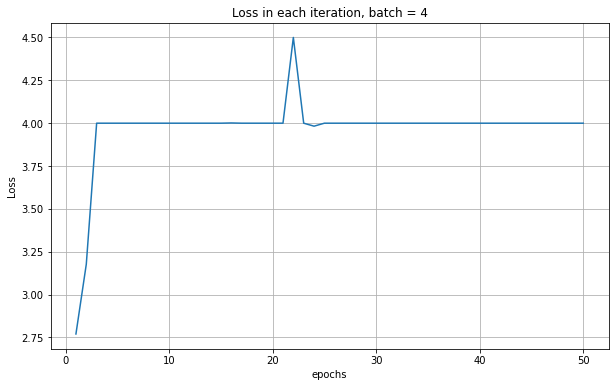

In [103]:
x_ax = np.linspace(1,len(L),len(L))
plt.figure(figsize=[10,6])
plt.plot(x_ax,L)
plt.title("Loss in each iteration, batch = %s"%batch)
#plt.text(0.5,1.5,'batch size = %s'%batch)

plt.ylabel("Loss",)
plt.xlabel("epochs")
plt.grid(True)
plt.show()

<Figure size 432x288 with 0 Axes>

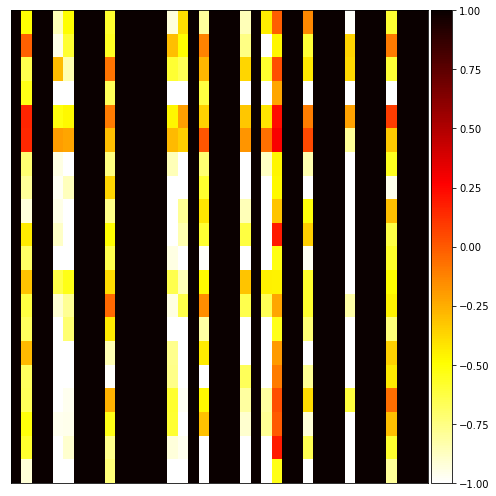

<Figure size 432x288 with 0 Axes>

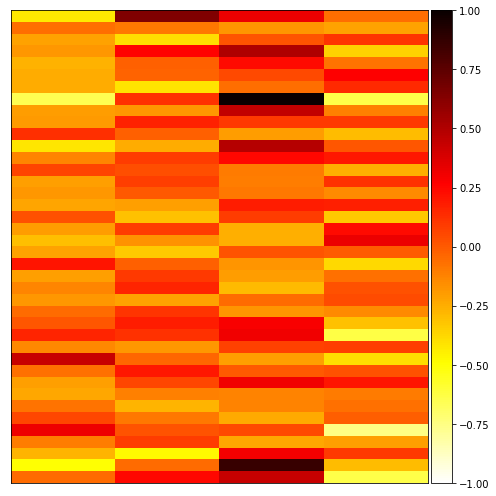

In [63]:
plt.figure()
plot_weights(forward_connection1.w,wmin=-1,figsize=[7,7])
plt.figure()
plot_weights(forward_connection2.w,wmin=-1,figsize=[7,7])
plt.show()


In [104]:
print(torch.max(forward_connection1.w))
print(torch.min(forward_connection1.w))
print(torch.max(forward_connection2.w))
print(torch.min(forward_connection2.w))
print("voltage threshold at the output layer ",network.layers["C"].thresh)
print("voltage threshold at the hidden layer ",network.layers["B"].thresh)

tensor(63.0213)
tensor(-2.2041)
tensor(0.6226)
tensor(-0.5824)
voltage threshold at the output layer  tensor([-64.3309, -64.3331, -64.3253, -64.3332])
voltage threshold at the hidden layer  tensor([-60.4390, -60.4466, -60.4615, -61.1270, -60.4412, -60.5534, -60.5064,
        -60.4694, -61.1270, -60.4473, -60.4372, -61.1270, -60.4519, -60.4552,
        -61.1275, -60.4558, -61.1270, -60.4459, -60.4446, -61.1273, -60.4591,
        -60.8458, -60.4450, -60.4938, -60.4614, -60.8094, -60.4535, -61.1270,
        -61.1270, -61.1270, -61.1270, -60.5061, -61.1270, -60.4353, -61.1271,
        -60.4634, -60.4486, -61.1270, -60.4741, -60.4351])


<Figure size 432x288 with 0 Axes>

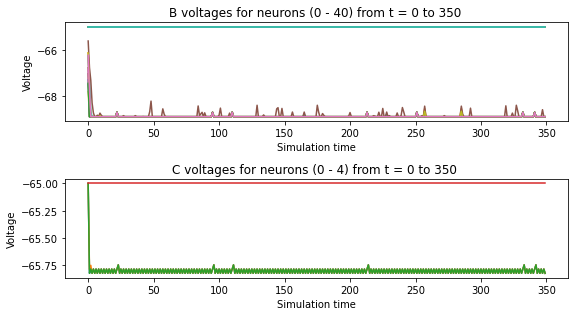

membrane voltage value before reset
tensor([[-65.0000, -68.8730, -65.0000, -65.0000, -68.8730, -68.8730, -65.0000,
         -65.0000, -65.0000, -68.8730, -65.0000, -65.0000, -65.0000, -65.0000,
         -65.0000, -68.8730, -68.8730, -65.0000, -68.8730, -65.0000, -65.0000,
         -65.0000, -68.8730, -65.0000, -68.8730, -68.8730, -65.0000, -65.0000,
         -68.8730, -65.0000, -65.0000, -65.0000, -68.8730, -65.0000, -65.0000,
         -65.0000, -68.8730, -65.0000, -65.0000, -65.0000]])
tensor([[-65.8216, -65.8216, -65.0000, -65.8216]])


In [65]:
#plot the voltage 
plt.figure()
plot_voltages(voltages, plot_type="line")
plt.show()
print("membrane voltage value before reset")
print(network.layers["B"].v)
print(network.layers["C"].v)

In [66]:
print(forward_connection1.w)
print(torch.sum(torch.pow((forward_connection1.w),2),dim=0))

Parameter containing:
tensor([[ 9.3887e+00, -4.9548e-01,  1.1281e+01,  9.2812e+00, -8.5303e-01,
         -4.8439e-01,  1.0623e+01,  4.7155e+00,  1.1102e+01, -5.8542e-01,
          1.1104e+01,  1.0591e+01,  1.1786e+01,  1.1022e+01,  1.0660e+01,
         -9.2579e-01, -3.9625e-01,  1.0824e+01, -7.9977e-01,  9.4587e+00,
          1.1178e+01,  1.0970e+01, -8.5354e-01,  1.1012e+01, -4.4306e-01,
         -1.1431e-02,  1.1264e+01,  9.4913e+00, -1.4044e-01,  8.1893e+00,
          1.0715e+01,  1.1309e+01, -9.8611e-01,  1.1210e+01,  9.9936e+00,
          5.7214e+00, -5.9236e-01,  1.0627e+01,  7.6284e+00,  8.3392e+00],
        [ 8.9047e+00, -1.9408e-02,  1.0284e+01,  9.3388e+00, -9.4984e-01,
         -5.8898e-01,  1.0152e+01,  4.5087e+00,  1.0004e+01, -5.5936e-01,
          1.0575e+01,  9.8137e+00,  1.0746e+01,  1.1089e+01,  1.0553e+01,
         -2.9845e-01, -4.8853e-01,  9.9018e+00, -1.1786e-01,  9.2741e+00,
          1.0672e+01,  1.0215e+01, -7.5462e-01,  9.8403e+00, -1.0043e+00,
         -4.658

In [67]:
print(forward_connection2.w)

Parameter containing:
tensor([[-0.4261,  0.6439,  0.3249, -0.0578],
        [-0.0612, -0.0931, -0.1741, -0.2119],
        [-0.2178, -0.3984,  0.0162,  0.1160],
        [-0.1817,  0.2635,  0.5005, -0.3570],
        [-0.2581, -0.0162,  0.2348, -0.0765],
        [-0.2496, -0.0302,  0.0541,  0.2710],
        [-0.2472, -0.4086, -0.0606,  0.1407],
        [-0.6487,  0.1186,  1.1301, -0.6379],
        [-0.1963, -0.1803,  0.4500, -0.1136],
        [-0.1902,  0.1661,  0.0979,  0.1002],
        [ 0.1297, -0.0163, -0.1976, -0.2933],
        [-0.4174, -0.2442,  0.4877,  0.0092],
        [-0.1321,  0.0899,  0.2484,  0.1957],
        [ 0.0691,  0.0363, -0.0976, -0.2500],
        [-0.2061,  0.0823, -0.1050,  0.1248],
        [-0.1803,  0.0020, -0.0915, -0.1430],
        [-0.2234, -0.2044,  0.1857,  0.1775],
        [ 0.0237, -0.3110,  0.0926, -0.3324],
        [-0.2015,  0.0862, -0.2547,  0.2361],
        [-0.3003, -0.1675, -0.2502,  0.3219],
        [-0.2115, -0.3356,  0.0233, -0.0039],
        [ 0.